# MPS using the deesse wrapper - continuous simulations


## Main points addressed:
- deesse simulation of a continuous variable
- various simulation modes for continuous variable

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os

# import from 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=11, micro=5, releaselevel='final', serial=0)
geone version: 1.2.4


## 1. Continuous simulation (standard mode)

### Training image (TI)
Read the training image. Source of the image: *T. Zhang, P. Switzer, and A. Journel, Filter-based classification of training image patterns for spatial simulation, MATHEMATICAL GEOLOGY, 38(1):63-80, JAN 2006,[ doi:10.1007/s11004-005-9004-x](https://dx.doi.org/10.1007/s11004-005-9004-x).*

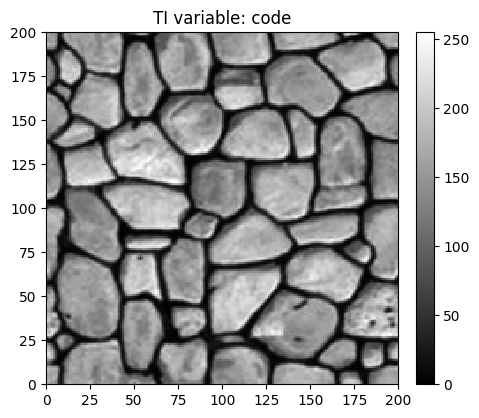

In [3]:
# Read file 
data_dir = 'data'
filename = os.path.join(data_dir, 'tiContinuous.txt')
ti = gn.img.readImageTxt(filename)

# Color settings
cmap='gray'
vmin, vmax = ti.vmin(), ti.vmax()

# Plot
plt.figure(figsize=(5,5))
gn.imgplot.drawImage2D(ti, cmap=cmap, vmin=vmin, vmax=vmax)
plt.title(f'TI variable: {ti.varname[0]}')
plt.show()

**Plotting in 3D using pyvista**

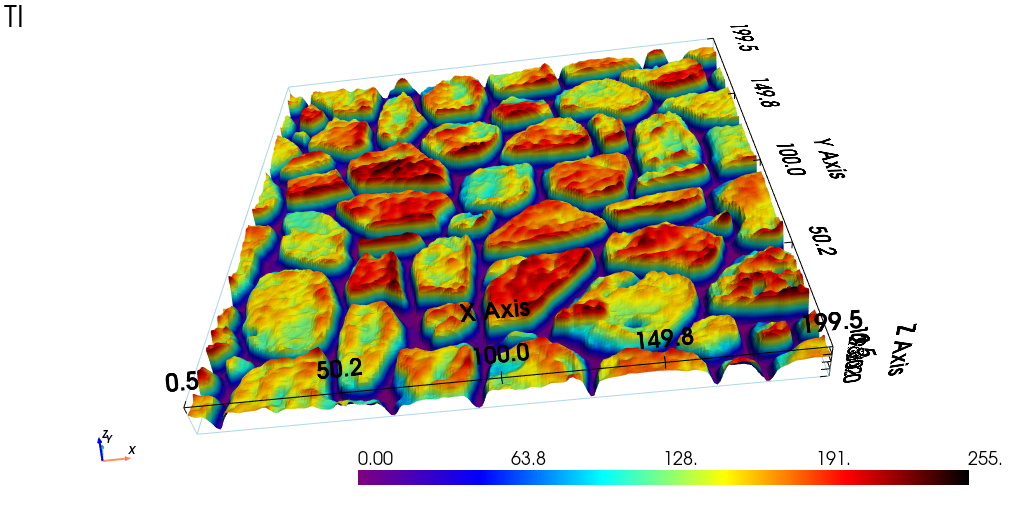

In [4]:
import pyvista as pv
pv.set_jupyter_backend('static') # to get static plots within the jupyter notebook

# 3D plot of TI
# -------------
z_factor = 0.05 # rescaling values for 3D plot

# Camera position
cpos=[(125., -200., 225.), (100., 110., -30.), (0.1, 0.65, 0.75)]
# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(window_size=(1024, 512), notebook=False)
# ... inline
pp = pv.Plotter(window_size=(1024, 512))

sgrid = pv.StructuredGrid(ti.xx()[0], ti.yy()[0], z_factor*ti.val[0,0])
#sgrid = pv.StructuredGrid(*np.meshgrid(ti.x(), ti.y()), z_factor*ti.val[0,0])# equivalent

#pp.add_mesh(sgrid, scalars=sgrid.elevation().active_scalars/z_factor, cmap=gn.customcolors.cmap2)
pp.add_mesh(sgrid, scalars=ti.val[0,0].T.reshape(-1), cmap=gn.customcolors.cmap2) # equivalent

pp.add_mesh(sgrid.outline())
pp.show_bounds()
pp.add_axes()
pp.add_text('TI', font_size=12)
pp.show(cpos=cpos)

### Simulation grid
Define the simulation grid (number of cells in each direction, cell unit, origin).

In [5]:
nx, ny, nz = 300, 120, 1         # number of cells
sx, sy, sz = ti.sx, ti.sy, ti.sz # cell unit
ox, oy, oz = 0.0, 0.0, 0.0       # origin (corner of the "first" grid cell)

### Hard data
Define some hard data (point set).

In [6]:
npt = 5 # number of points
nv = 4   # number of variables including x, y, z coordinates
varname = ['x', 'y', 'z', 'code'] # list of variable names
v = np.array([
    [ 10.5,  20.5, 0.5,  30], # x, y, z, code: 1st point
    [229.5,  21.5, 0.5, 132], # ...
    [ 98.5,  27.5, 0.5,  10],
    [245.5,  94.5, 0.5, 189],
    [ 87.5, 110.5, 0.5,   2]
    ]).T # variable values: (nv, npt)-array
hd = gn.img.PointSet(npt=npt, nv=nv, varname=varname, val=v)

Plot the hard data points in the simulation grid.

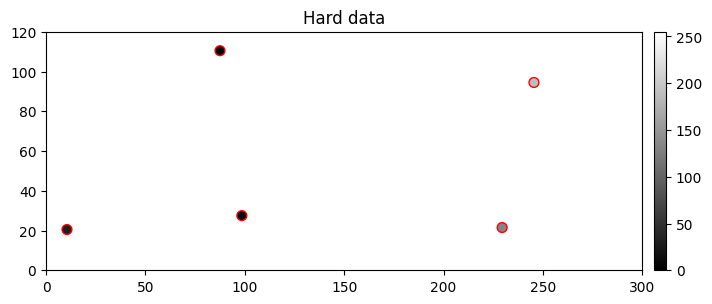

In [7]:
# Get the colors for values of the variable of index 3 in the point set, 
# according to the color settings used for the TI
hd_col = gn.imgplot.get_colors_from_values(hd.val[3], cmap=cmap, vmin=vmin, vmax=vmax)

# Set an image with simulation grid geometry defined above, and no variable
im_empty = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=0)

# Plot
plt.figure(figsize=(8,5))

# Plot empty simulation grid and specify colors
gn.imgplot.drawImage2D(im_empty, cmap=cmap, vmin=vmin, vmax=vmax)

# Add hard data points
plt.scatter(hd.x(), hd.y(), marker='o', s=50, color=hd_col, edgecolors='red', linewidths=1)

plt.title('Hard data')
plt.show()

### Fill the input structure for deesse and launch deesse
**Reminder:** variable name for the hard data (in `hd.varname`) and for the simulated variable (`varname` below) should be the same, otherwise, the hard data will be ignored.

In [8]:
nreal = 20
deesse_input = gn.deesseinterface.DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=1, varname='code',
    TI=ti,
    dataPointSet=hd,
    distanceType='continuous',           # distance type: L1 (continuous variable)
    nneighboringNode=24,
    distanceThreshold=0.02,
    maxScanFraction=0.25,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

# Run deesse
t1 = time.time() # start time
deesse_output = gn.deesseinterface.deesseRun(deesse_input)
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.2g} sec')

DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230914 / OpenMP 19 thread(s)]
DeeSse run complete
Elapsed time: 45 sec


### Retrieve the results (and display)

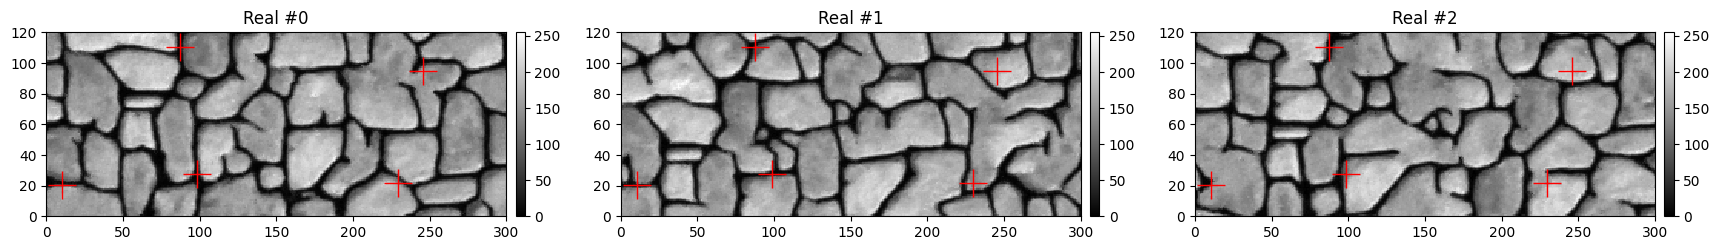

In [9]:
# Retrieve the realizations
sim = deesse_output['sim']

# Display
plt.subplots(1,3, figsize=(21,3)) # 1 x 3 sub-plots
for i in range(3):
    plt.subplot(1, 3, i+1) # select next sub-plot
    gn.imgplot.drawImage2D(sim[i], cmap=gn.customcolors.cmapB2W, vmin=ti.vmin(), vmax=ti.vmax(), 
                           title=f'Real #{i}') # plot real #i
    plt.plot(hd.x(), hd.y(), '+', markersize=20, c='red') # add hard data points
plt.show()

### Do some statistics on the realizations
The function `geone.img.imageContStat(im, op)` allows to compute the pixel-wise operation `op` (mean, standard deviation for examples) over all the variables of the image `im`. First, an image with `nreal` variables, each one corresponding to one realization, is defined (from the array of realizations) using the function `geone.img.gatherImages`.

Alternatively, the function `geone.img.imageListContStat(im_list, op, ind)` can be used directly to compute the pixel-wise statistics according to operation `op` over the variable of index `ind` of all the images in the list `im_list`.

In [12]:
# Gather the nreal realizations into one image
all_sim = gn.img.gatherImages(sim) # all_sim is one image with nreal variables

# Do statistics over all the realizations: compute the pixel-wise mean and standard deviation
all_sim_mean = gn.img.imageContStat(all_sim, op='mean') # do statistics (pixel-wise mean)
all_sim_std = gn.img.imageContStat(all_sim, op='std')   # do statistics (pixel-wise standard deviation)

In [13]:
# Equivalently:
all_sim_mean2 = gn.img.imageListContStat(sim, op='mean')
print("Same result (mean) ?", gn.img.isImageEqual(all_sim_mean, all_sim_mean2)) # should be True

all_sim_std2 = gn.img.imageListContStat(sim, op='std')
print("Same result (std) ?", gn.img.isImageEqual(all_sim_std, all_sim_std2)) # should be True

Same result (mean) ? True
Same result (std) ? True


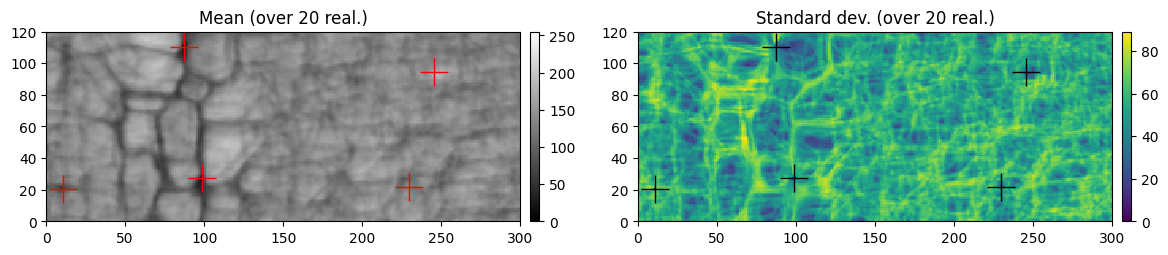

In [14]:
# Display
plt.subplots(1,2, figsize=(14,3)) # 1 x 2 plots

plt.subplot(1,2,1) # select 1st sub-plot
gn.imgplot.drawImage2D(all_sim_mean, cmap=gn.customcolors.cmapB2W, vmin=ti.vmin(), vmax=ti.vmax(), 
                       title=f'Mean (over {nreal} real.)')
plt.plot(hd.x(), hd.y(), '+', markersize=20, c='r') # add hard data points

plt.subplot(1,2,2) # select 2nd sub-plot
gn.imgplot.drawImage2D(all_sim_std, title=f'Standard dev. (over {nreal} real.)')
plt.plot(hd.x(), hd.y(), '+', markersize=20, c='k') # add hard data points

plt.show()

## 2. Continuous simulation using a specific target interval of values

Ususally, the simulated variable takes values in the range of the training image values, i.e. the target interval (for the simulated variable) is equal to the TI interval. In particular, in presence of hard data, their values should be in that interval.

However, one can specify a different target interval, which should contain any hard data value. A linear correspondence is set between the target interval and the TI interval. The target interval can be specified following two ways (mode, `rescalingMode`):
    
- Mode `min_max`: one gives the minimal and maximal values of the target interval (`rescalingTargetMin` and `rescalingTargetMax`) that correspond to the minimal and maximal TI values.

- Mode `mean_length`: one gives a mean value (`rescalingTargetMean`) that corresponds to the mean of TI values and the length of the target interval.

### Continuous simulation using the rescaling mode `min_max`

In [15]:
targetMin, targetMax = -10, 10 # min and max value of the target interval

# Hard data with value of the variable in the target interval
npt = 5 # number of points
nv = 4  # number of variables including x, y, z coordinates
varname = ['x', 'y', 'z', 'code'] # list of variable names
v = np.array([
    [ 10.5,  20.5, 0.5,  -9  ], # x, y, z, code: 1st point
    [229.5,  21.5, 0.5,   2.2], # ...
    [ 98.5,  27.5, 0.5,  -7.0],
    [245.5,  94.5, 0.5,   9.0],
    [ 87.5, 110.5, 0.5,   2.0]
    ]).T # variable values: (nv,npt)-array
hd = gn.img.PointSet(npt=npt, nv=nv, varname=varname, val=v)

# Deesse input
deesse_input = gn.deesseinterface.DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=1, varname='code',
    TI=ti,
    dataPointSet=hd,
    distanceType='continuous',
    rescalingMode='min_max',      # set rescaling mode
    rescalingTargetMin=targetMin, # min of the target interval
    rescalingTargetMax=targetMax, # max of the target interval
    nneighboringNode=24,
    distanceThreshold=0.02,
    maxScanFraction=0.25,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

# Run deesse
t1 = time.time() # start time
deesse_output = gn.deesseinterface.deesseRun(deesse_input)
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.2g} sec')

DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230914 / OpenMP 19 thread(s)]
DeeSse run complete
Elapsed time: 44 sec


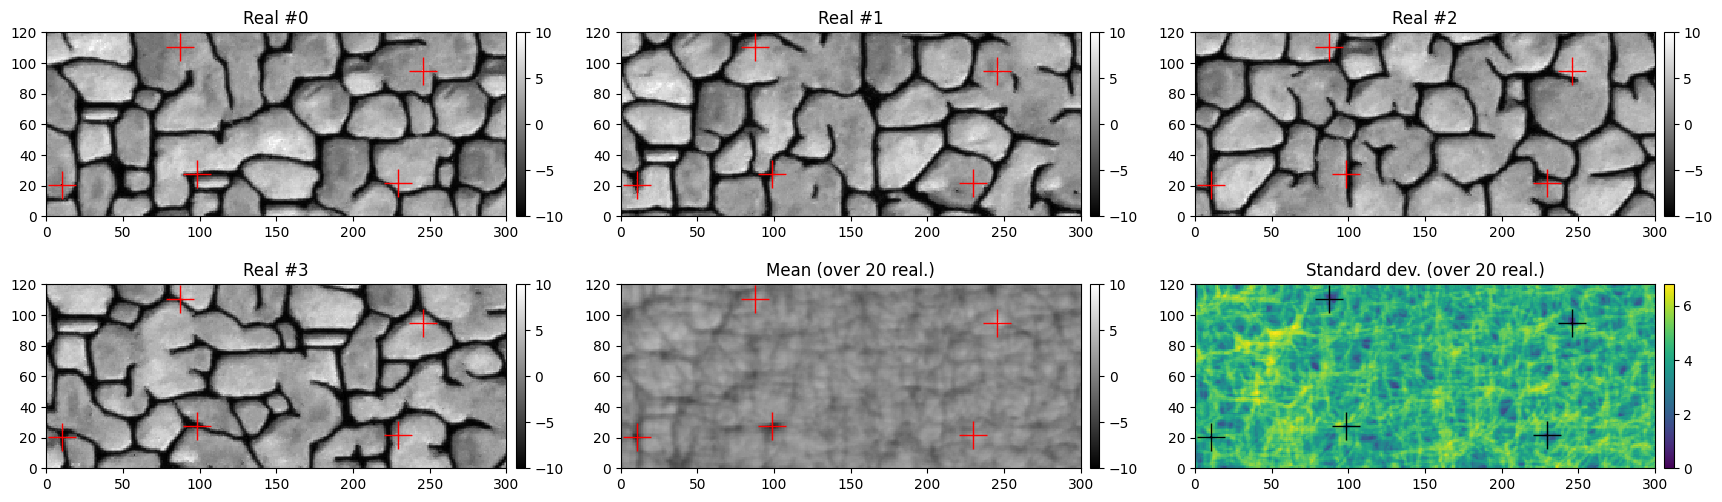

In [17]:
# Retrieve the realizations
sim = deesse_output['sim']

# Do some statistics on the realizations
all_sim = gn.img.gatherImages(sim) # all_sim is one image with nreal variables
all_sim_mean = gn.img.imageContStat(all_sim, op='mean') # do statistics (pixel-wise mean)
all_sim_std = gn.img.imageContStat(all_sim, op='std')   # do statistics (pixel-wise standard deviation)

# Display
plt.subplots(2,3, figsize=(21,6)) # 2 x 3 sub-plots
for i in range(4):
    plt.subplot(2, 3, i+1) # select next sub-plot
    gn.imgplot.drawImage2D(sim[i], cmap=gn.customcolors.cmapB2W, vmin=targetMin, vmax=targetMax, 
                           title=f'Real #{i}') # plot real #i
    plt.plot(hd.x(), hd.y(), '+', markersize=20, c='red') # add hard data points

plt.subplot(2,3,5) # select 5th sub-plot
gn.imgplot.drawImage2D(all_sim_mean, cmap=gn.customcolors.cmapB2W, vmin=targetMin, vmax=targetMax, 
                       title=f'Mean (over {nreal} real.)')
plt.plot(hd.x(), hd.y(), '+', markersize=20, c='r') # add hard data points

plt.subplot(2,3,6) # select 6th sub-plot
gn.imgplot.drawImage2D(all_sim_std, title=f'Standard dev. (over {nreal} real.)')
plt.plot(hd.x(), hd.y(), '+', markersize=20, c='k') # add hard data points

plt.show()

### Continuous simulation using the rescaling mode `mean_length`

In [18]:
targetMean, targetLength = -5, 30 # mean and length of the target interval

# Deesse input
deesse_input = gn.deesseinterface.DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=1, varname='code',
    TI=ti,
    dataPointSet=hd,
    distanceType='continuous',
    rescalingMode='mean_length',        # set rescaling mode
    rescalingTargetMean=targetMean,     # mean for the target interval
    rescalingTargetLength=targetLength, # length of the target interval
    nneighboringNode=24,
    distanceThreshold=0.02,
    maxScanFraction=0.25,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

# Run deesse
t1 = time.time() # start time
deesse_output = gn.deesseinterface.deesseRun(deesse_input)
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.2g} sec')

DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230914 / OpenMP 19 thread(s)]
DeeSse run complete
Elapsed time: 43 sec


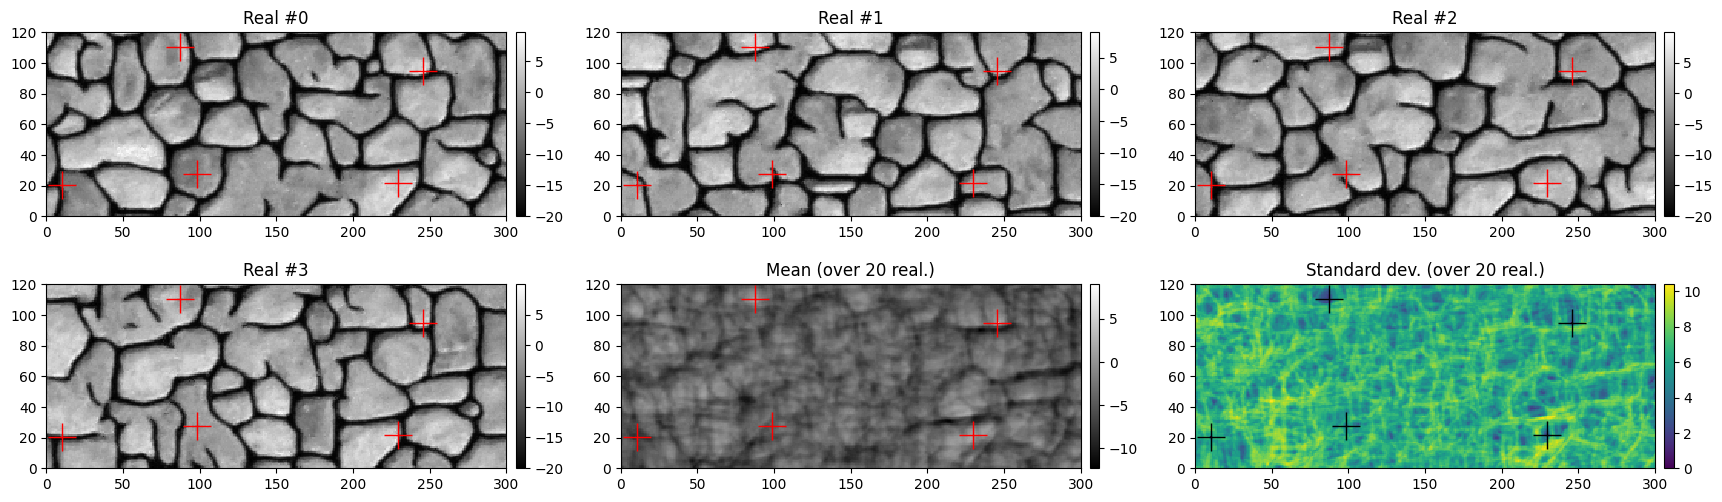

In [19]:
# Retrieve the realizations
sim = deesse_output['sim']

# Do some statistics on the realizations
all_sim = gn.img.gatherImages(sim) # all_sim is one image with nreal variables
all_sim_mean = gn.img.imageContStat(all_sim, op='mean') # do statistics (pixel-wise mean)
all_sim_std = gn.img.imageContStat(all_sim, op='std')   # do statistics (pixel-wise standard deviation)

# Display
plt.subplots(2,3, figsize=(21,6)) # 2 x 3 plots
for i in range(4):
    plt.subplot(2, 3, i+1) # select next sub-plot
    gn.imgplot.drawImage2D(sim[i], cmap=gn.customcolors.cmapB2W,
                           title=f'Real #{i}') # plot real #i
    plt.plot(hd.x(), hd.y(), '+', markersize=20, c='red') # add hard data points

plt.subplot(2,3,5) # select 5th sub-plot
gn.imgplot.drawImage2D(all_sim_mean, cmap=gn.customcolors.cmapB2W,
                       title=f'Mean (over {nreal} real.)')
plt.plot(hd.x(), hd.y(), '+', markersize=20, c='red') # add hard data points

plt.subplot(2,3,6) # select 6th sub-plot
gn.imgplot.drawImage2D(all_sim_std, title=f'Standard dev. (over {nreal} real.)')
plt.plot(hd.x(), hd.y(), '+', markersize=20, c='k') # add hard data points

plt.show()

## 3. Continuous simulation using relative distance

For continuous variable, one can use relative distance (`relativeDistanceFlag`) to compare the patterns. Using this mode, any *original* pattern is first modified by substracting the mean value over the nodes of that pattern, and then the comparison (computation of distance) is done. 

In particular, this allows to simulate values not in the same range of the TI values and to implicitly give a trend by a hard data set.

**Remark**. When relative distance is activated, it can be helpful to limit the size of the search ellipsoid in order to find similar patterns in the training image during the simulation.

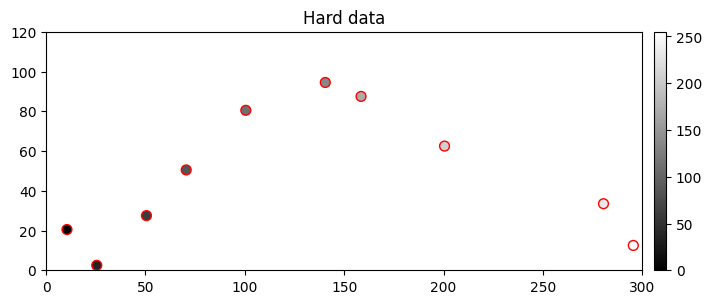

In [20]:
# Hard data with value depicting a trend from left to right
npt = 10 # number of points
nv = 4   # number of variables including x, y, z coordinates
varname = ['x', 'y', 'z', 'code'] # list of variable names
v = np.array([
    [ 10.5,  20.5, 0.5,  -9  ], # x, y, z, code: 1st point
    [ 25.5,   2.5, 0.5,  50.2], # ...
    [ 50.5,  27.5, 0.5,  93.0],
    [ 70.5,  50.5, 0.5, 134.3],
    [100.5,  80.5, 0.5, 178.0],
    [140.5,  94.5, 0.5, 220.0],
    [158.5,  87.5, 0.5, 278.0],
    [200.5,  62.5, 0.5, 342.0],
    [280.5,  33.5, 0.5, 380.0],
    [295.5,  12.5, 0.5, 420.0]
    ]).T # variable values: (nv,npt)-array
hd = gn.img.PointSet(npt=npt, nv=nv, varname=varname, val=v)

# Figure
# ------
# Get the colors for values of the variable of index 3 in the point set, 
# according to the given cmap (and min and max values of the variable in the point set)
hd_col = gn.imgplot.get_colors_from_values(hd.val[3], cmap=cmap)

# Set an image with simulation grid geometry defined above, and no variable
im_empty = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=0)

# Plot
plt.figure(figsize=(8,5))

# Plot empty simulation grid and specify colors
gn.imgplot.drawImage2D(im_empty, cmap=cmap, vmin=vmin, vmax=vmax)

# Add hard data points
plt.scatter(hd.x(), hd.y(), marker='o', s=50, color=hd_col, edgecolors='red', linewidths=1)

plt.title('Hard data')
plt.show()

In [21]:
# Deesse input
deesse_input = gn.deesseinterface.DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=1, varname='code',
    TI=ti,
    dataPointSet=hd,
    distanceType='continuous',
    relativeDistanceFlag=True, # set relative distance
    nneighboringNode=24,
    distanceThreshold=0.05,
    maxScanFraction=0.25,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

# Run deesse
t1 = time.time() # start time
deesse_output = gn.deesseinterface.deesseRun(deesse_input)
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.2g} sec')

DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230914 / OpenMP 19 thread(s)]
DeeSse run complete
Elapsed time: 67 sec


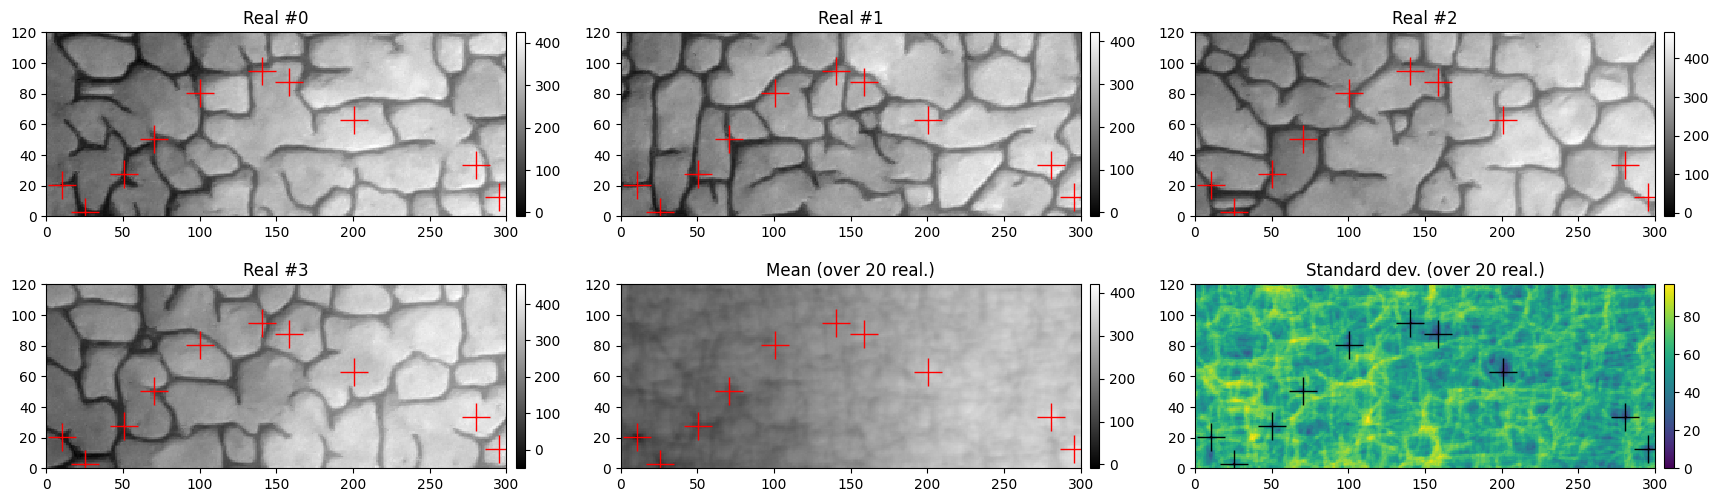

In [22]:
# Retrieve the realizations
sim = deesse_output['sim']

# Do some statistics on the realizations
all_sim = gn.img.gatherImages(sim) # all_sim is one image with nreal variables
all_sim_mean = gn.img.imageContStat(all_sim, op='mean') # do statistics (pixel-wise mean)
all_sim_std = gn.img.imageContStat(all_sim, op='std')   # do statistics (pixel-wise standard deviation)

# Display
plt.subplots(2,3, figsize=(21,6)) # 2 x 3 sub-plots
for i in range(4):
    plt.subplot(2, 3, i+1) # select next sub-plot
    gn.imgplot.drawImage2D(sim[i], cmap=gn.customcolors.cmapB2W,
                           title=f'Real #{i}') # plot real #i
    plt.plot(hd.x(), hd.y(), '+', markersize=20, c='red') # add hard data points

plt.subplot(2,3,5) # select 5th sub-plot
gn.imgplot.drawImage2D(all_sim_mean, cmap=gn.customcolors.cmapB2W,
                       title=f'Mean (over {nreal} real.)')
plt.plot(hd.x(), hd.y(), '+', markersize=20, c='red') # add hard data points

plt.subplot(2,3,6) # select 6th sub-plot
gn.imgplot.drawImage2D(all_sim_std, title=f'Standard dev. (over {nreal} real.)')
plt.plot(hd.x(), hd.y(), '+', markersize=20, c='k') # add hard data points

plt.show()